In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is NOT available.")

GPU is available.


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer


In [4]:
# Define paths
train_dir = '/content/drive/MyDrive/kidney/ds/train/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin model expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.6, 0.5, 0.6), (0.5, 0.6, 0.5))
])

# Load dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)


# Define data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
total_images = len(train_dataset)
print(f"Total number of images in test dataset: {total_images}")

Total number of images in test dataset: 2000


In [6]:
model_name = "facebook/deit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True  # Ignore size mismatches in the model
)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
num_classes = len(train_dataset.classes)
model.classifier = nn.Linear(model.config.hidden_size, num_classes)


In [8]:
num_classes

2

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
learning_rate = 1e-4          # Learning rate
num_epochs = 5                # Number of training epochs
batch_size = 32               # Batch size
momentum = 0.9                # Momentum for optimizer
weight_decay = 1e-5           # Weight decay for regularization
num_classes = len(train_dataset.classes)  # Number of classes
loss_function = 'CrossEntropy'  # Use CrossEntropy for classification

# Initialize lists to store loss and accuracy
los = []
train_accuracy = []

# Set up the loss function and optimizer
if loss_function == 'MSE':  # If MSE is needed for regression
    criterion = nn.MSELoss()
else:  # Default to CrossEntropyLoss for classification
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # Model outputs logits
        loss = criterion(outputs.logits, labels)  # Use CrossEntropyLoss which expects logits and class indices
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, preds = torch.max(outputs.logits, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_predictions / total_samples

    # Print loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Append loss and accuracy to the lists
    los.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)


Epoch 1/5, Loss: 0.0308, Accuracy: 0.9845
Epoch 2/5, Loss: 0.0000, Accuracy: 1.0000
Epoch 3/5, Loss: 0.0000, Accuracy: 1.0000
Epoch 4/5, Loss: 0.0000, Accuracy: 1.0000
Epoch 5/5, Loss: 0.0000, Accuracy: 1.0000


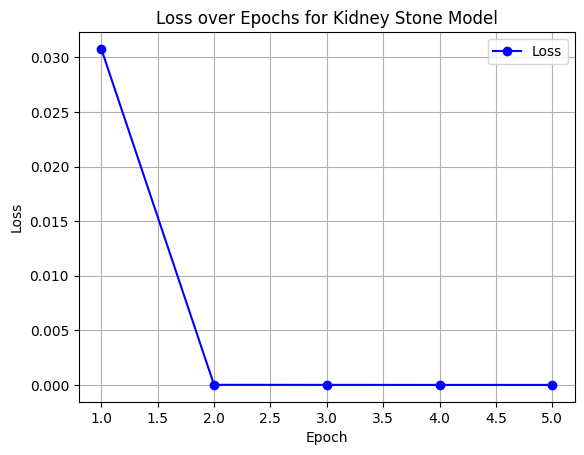

In [11]:
import matplotlib.pyplot as plt


# Number of epochs
epochs = list(range(1, len(los) + 1))

# Plot the loss values
plt.plot(epochs, los, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for Kidney Stone Model')
plt.legend()
plt.grid(True)
plt.show()

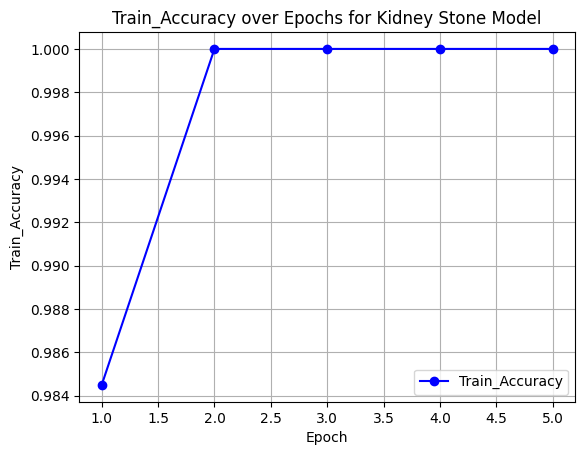

In [12]:
import matplotlib.pyplot as plt


# Number of epochs
epochs = list(range(1, len(train_accuracy) + 1))

# Plot the loss values
plt.plot(epochs, train_accuracy, marker='o', linestyle='-', color='b', label='Train_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Train_Accuracy')
plt.title('Train_Accuracy over Epochs for Kidney Stone Model')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
test_dir = '/content/drive/MyDrive/kidney/ds/test/'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [84]:
total_images = len(test_dataset)
print(f"Total number of images in test dataset: {total_images}")

Total number of images in test dataset: 1200


Streaming output truncated to the last 5000 lines.
153
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999963045120239
True Prediction
154
Actual label: Normal
Predicted label: Normal
Confidence: 0.999996542930603
True Prediction
155
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999966621398926
True Prediction
156
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999964237213135
True Prediction
157
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999964237213135
True Prediction
158
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999964237213135
True Prediction
159
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999964237213135
True Prediction
160
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999963045120239
True Prediction
161
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999960660934448
True Prediction
162
Actual label: Normal
Predicted label: Normal
Confidence: 0.9999959468841553
True P

1153
Actual label: stone
Predicted label: stone
Confidence: 0.9999880790710449
True Prediction
1154
Actual label: stone
Predicted label: stone
Confidence: 0.999995231628418
True Prediction
1155
Actual label: stone
Predicted label: stone
Confidence: 0.9999957084655762
True Prediction
1156
Actual label: stone
Predicted label: stone
Confidence: 0.9999921321868896
True Prediction
1157
Actual label: stone
Predicted label: stone
Confidence: 0.9999887943267822
True Prediction
1158
Actual label: stone
Predicted label: stone
Confidence: 0.9999946355819702
True Prediction
1159
Actual label: stone
Predicted label: stone
Confidence: 0.9999953508377075
True Prediction
1160
Actual label: stone
Predicted label: stone
Confidence: 0.9999960660934448
True Prediction
1161
Actual label: stone
Predicted label: stone
Confidence: 0.9999949932098389
True Prediction
1162
Actual label: stone
Predicted label: Normal
Confidence: 0.9999451637268066


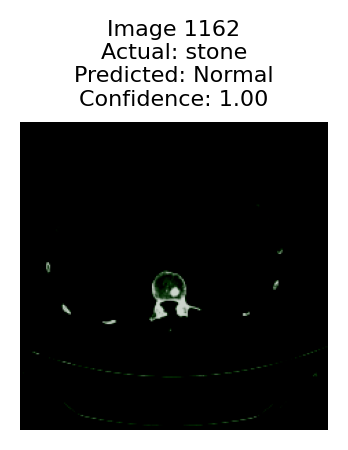

1163
Actual label: stone
Predicted label: Normal
Confidence: 0.9999372959136963


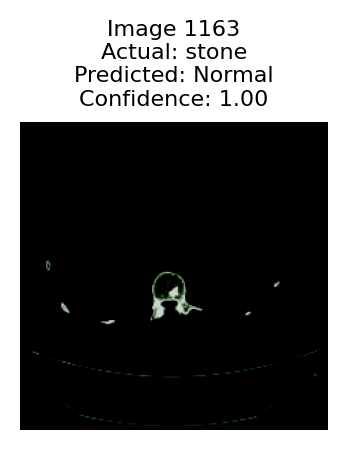

1164
Actual label: stone
Predicted label: Normal
Confidence: 0.9999438524246216


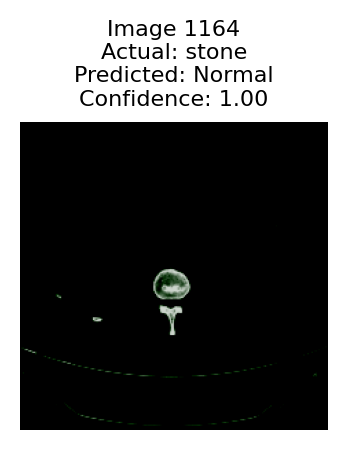

1165
Actual label: stone
Predicted label: Normal
Confidence: 0.9999657869338989


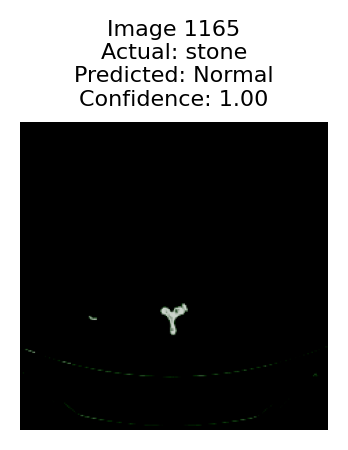

1166
Actual label: stone
Predicted label: Normal
Confidence: 0.9999606609344482


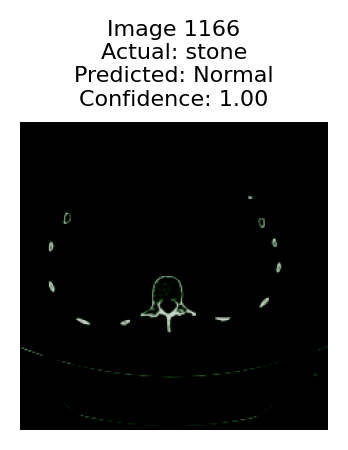

1167
Actual label: stone
Predicted label: Normal
Confidence: 0.9999547004699707


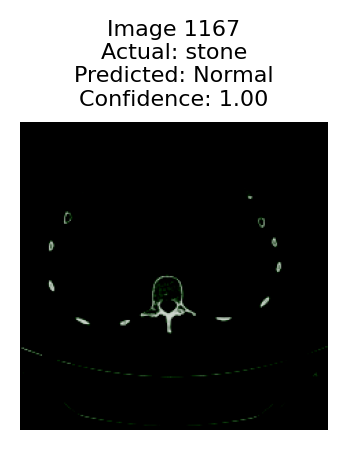

1168
Actual label: stone
Predicted label: Normal
Confidence: 0.9999892711639404


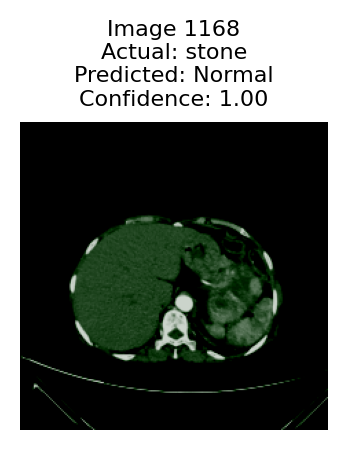

1169
Actual label: stone
Predicted label: Normal
Confidence: 0.9999901056289673


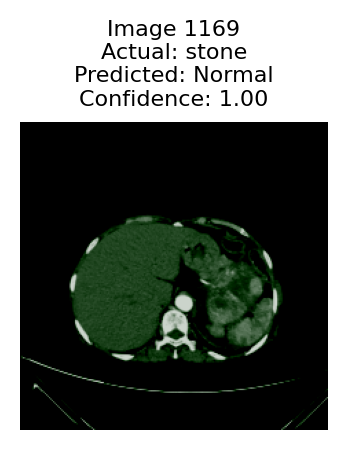

1170
Actual label: stone
Predicted label: Normal
Confidence: 0.9999897480010986


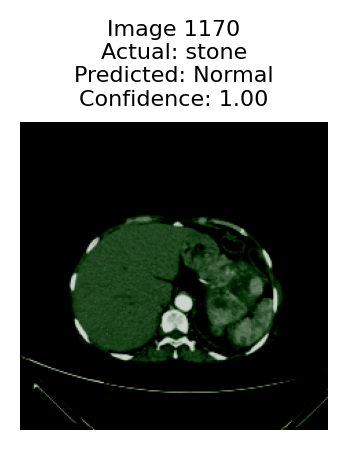

1171
Actual label: stone
Predicted label: Normal
Confidence: 0.9999905824661255


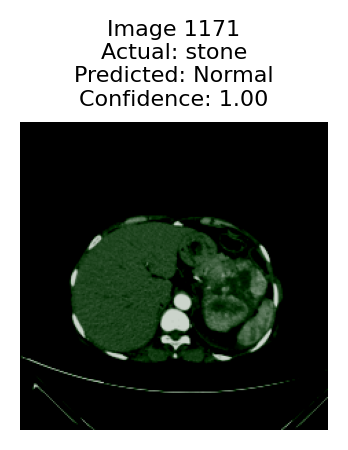

1172
Actual label: stone
Predicted label: Normal
Confidence: 0.999990701675415


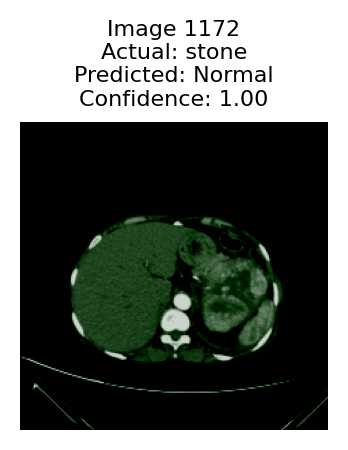

1173
Actual label: stone
Predicted label: Normal
Confidence: 0.9999895095825195


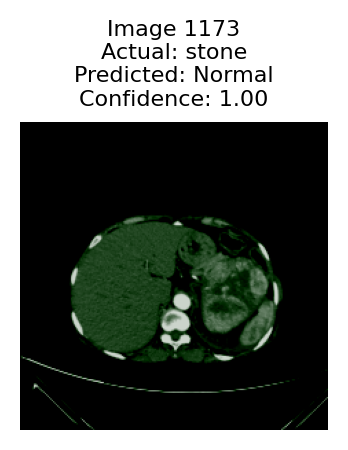

1174
Actual label: stone
Predicted label: Normal
Confidence: 0.9999898672103882


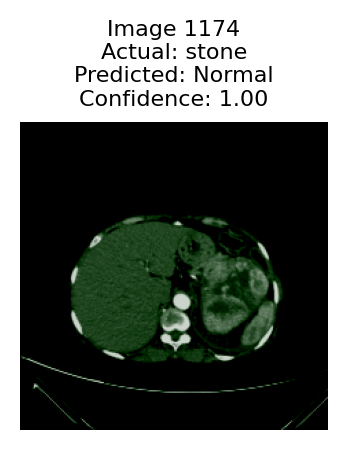

1175
Actual label: stone
Predicted label: Normal
Confidence: 0.9999904632568359


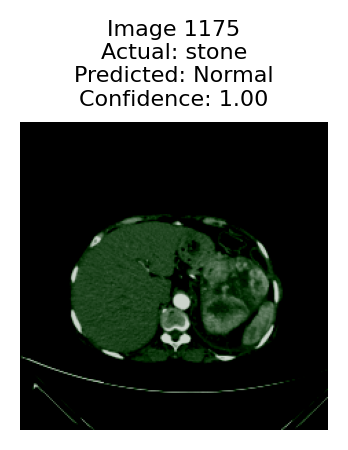

1176
Actual label: stone
Predicted label: Normal
Confidence: 0.9999901056289673


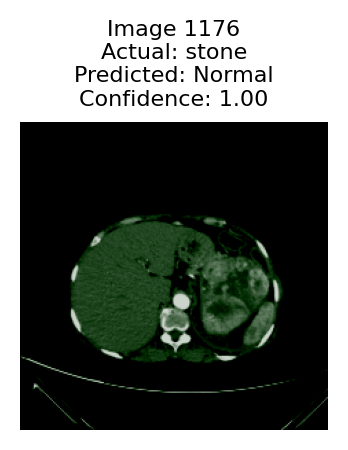

1177
Actual label: stone
Predicted label: Normal
Confidence: 0.9999904632568359


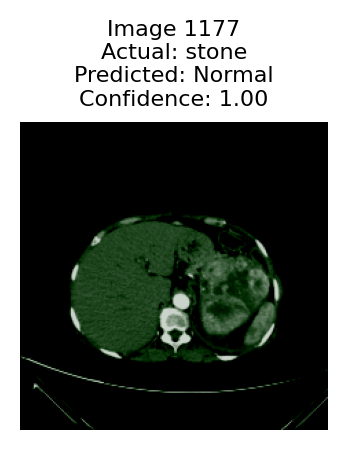

1178
Actual label: stone
Predicted label: Normal
Confidence: 0.9999896287918091


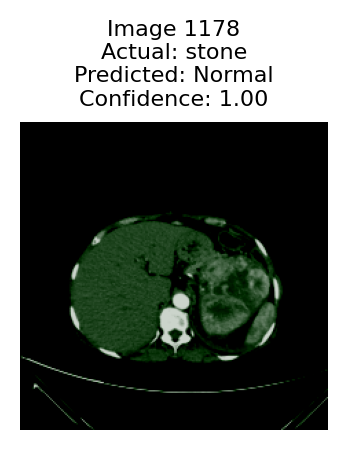

1179
Actual label: stone
Predicted label: Normal
Confidence: 0.9999899864196777


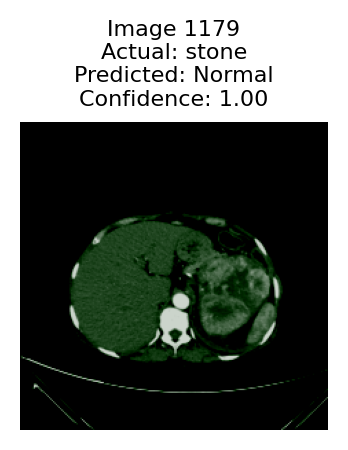

1180
Actual label: stone
Predicted label: Normal
Confidence: 0.9999903440475464


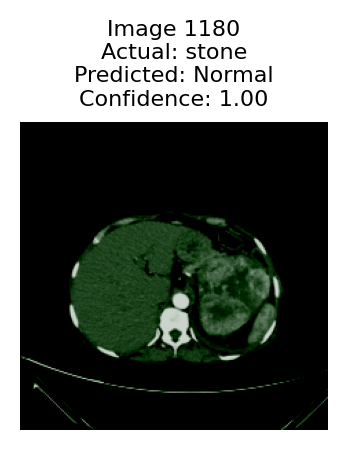

1181
Actual label: stone
Predicted label: Normal
Confidence: 0.9999904632568359


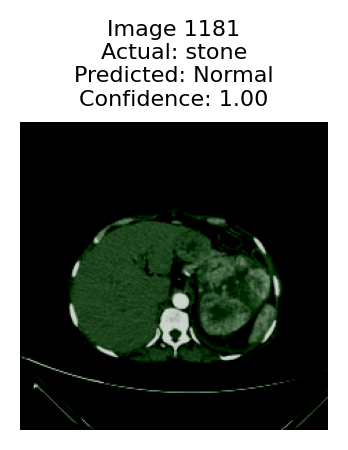

1182
Actual label: stone
Predicted label: Normal
Confidence: 0.9999921321868896


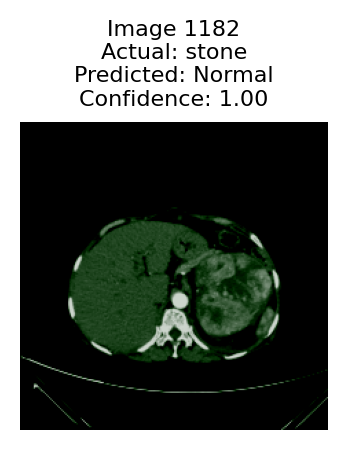

1183
Actual label: stone
Predicted label: Normal
Confidence: 0.9999922513961792


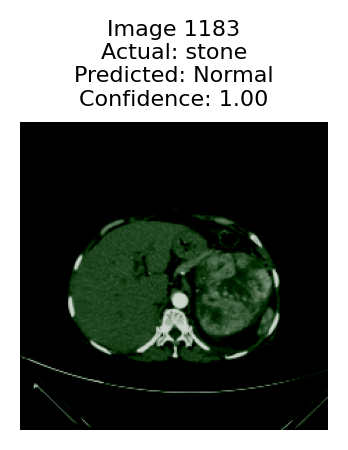

1184
Actual label: stone
Predicted label: Normal
Confidence: 0.9999922513961792


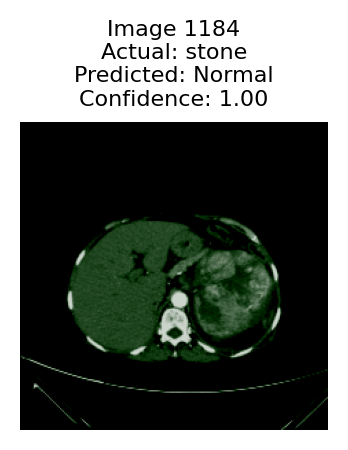

1185
Actual label: stone
Predicted label: Normal
Confidence: 0.9999923706054688


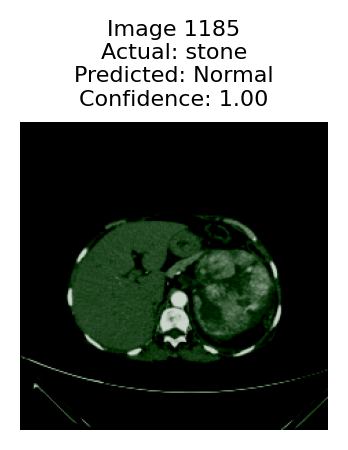

1186
Actual label: stone
Predicted label: Normal
Confidence: 0.9999926090240479


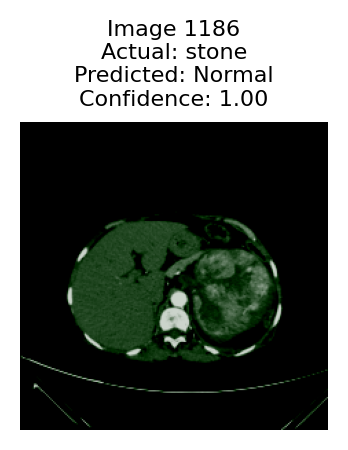

1187
Actual label: stone
Predicted label: Normal
Confidence: 0.9999918937683105


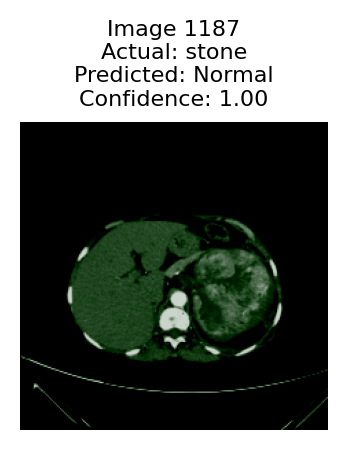

1188
Actual label: stone
Predicted label: Normal
Confidence: 0.9999916553497314


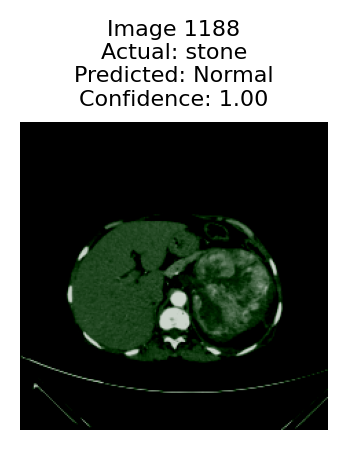

1189
Actual label: stone
Predicted label: Normal
Confidence: 0.999991774559021


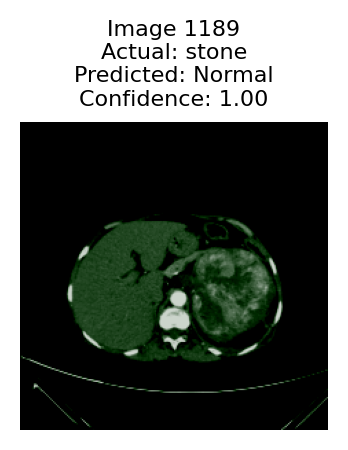

1190
Actual label: stone
Predicted label: Normal
Confidence: 0.9999915361404419


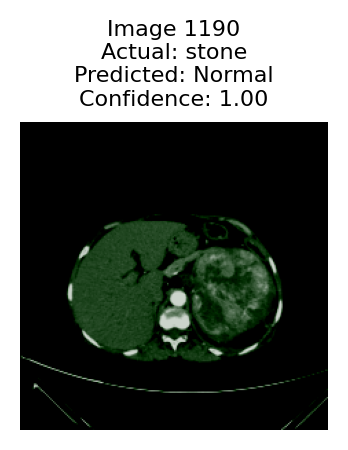

1191
Actual label: stone
Predicted label: Normal
Confidence: 0.9999914169311523


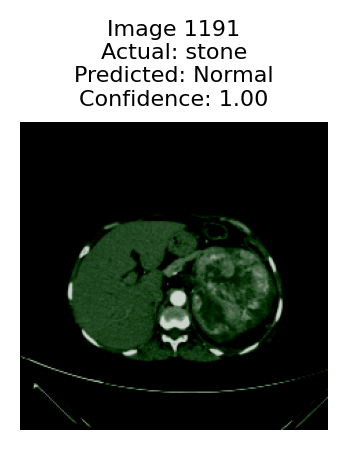

1192
Actual label: stone
Predicted label: Normal
Confidence: 0.999993085861206


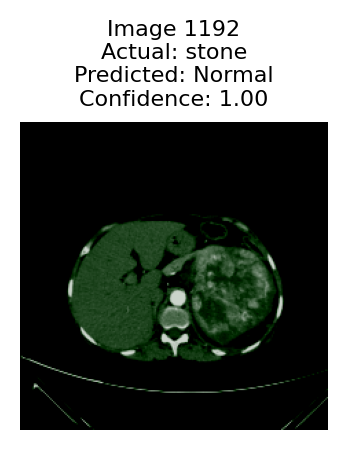

1193
Actual label: stone
Predicted label: Normal
Confidence: 0.9999927282333374


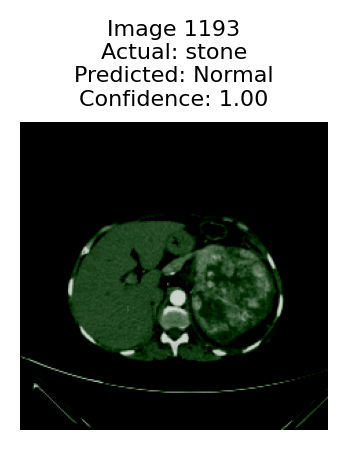

1194
Actual label: stone
Predicted label: Normal
Confidence: 0.9999921321868896


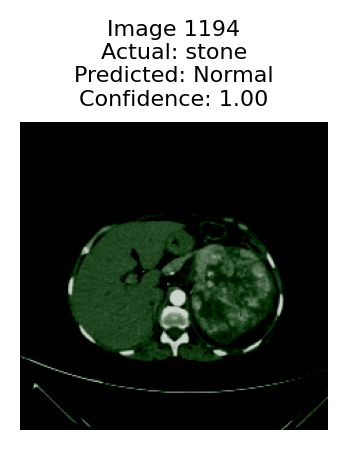

1195
Actual label: stone
Predicted label: Normal
Confidence: 0.9999921321868896


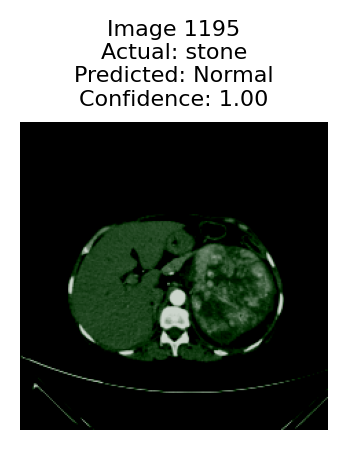

1196
Actual label: stone
Predicted label: Normal
Confidence: 0.999992847442627


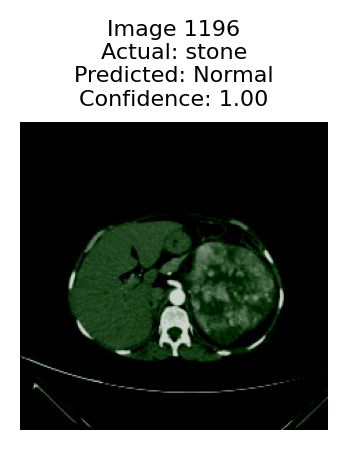

1197
Actual label: stone
Predicted label: Normal
Confidence: 0.9999933242797852


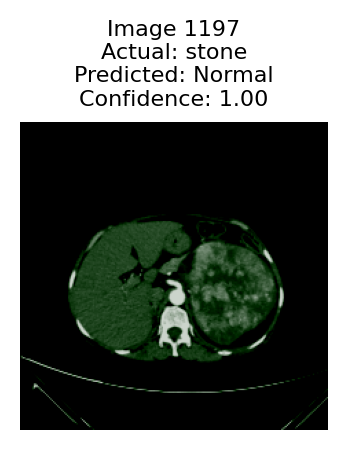

1198
Actual label: stone
Predicted label: Normal
Confidence: 0.9999936819076538


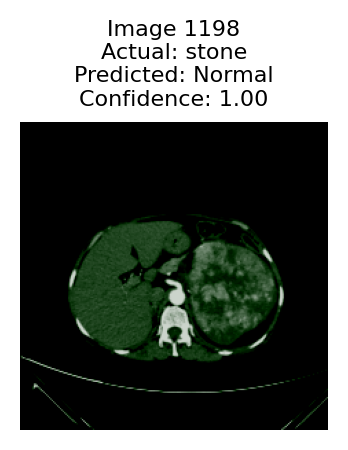

1199
Actual label: stone
Predicted label: Normal
Confidence: 0.9999934434890747


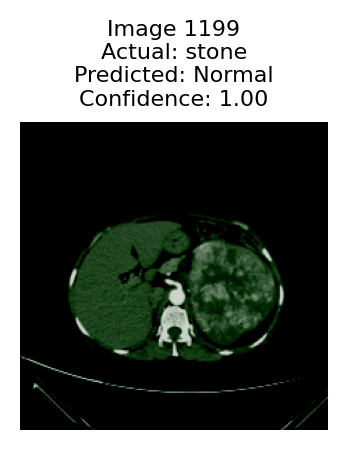

1200
Actual label: stone
Predicted label: Normal
Confidence: 0.9999934434890747


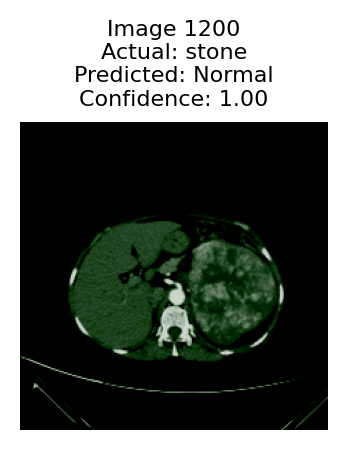

In [85]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

class_names = test_dataset.classes
actual = []
predicted = []
imageName = []
conf = []


# Function to display an image along with its labels
def show_image(img, actual_label, predicted_label, confidence, idx):
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and permute dimensions

    # Create a figure with high resolution but small size
    plt.figure(figsize=(2, 2), dpi=200)  # Small figure size with high dpi for clarity
    plt.imshow(img)
    plt.xlabel('X-axis (Pixels)')
    plt.ylabel('Y-axis (Pixels)')
    plt.title(f"Image {idx}\nActual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}", fontsize=8)
    plt.axis('off')
    plt.show()

j = 1
for images, labels in test_dataloader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    predicted_labels = torch.argmax(outputs.logits, dim=1)

    # Map predicted labels to class names
    predicted_class_names = [class_names[label] for label in predicted_labels]
    predicted_probs = F.softmax(outputs.logits, dim=1)
    confidences = torch.max(predicted_probs, dim=1).values

    # Convert actual labels to class names
    actual_class_names = [class_names[label] for label in labels.tolist()]

    for i in range(len(images)):
        print(j)
        print("Actual label:", actual_class_names[i])
        actual.append(actual_class_names[i])
        print("Predicted label:", predicted_class_names[i])
        predicted.append(predicted_class_names[i])
        imageName.append(j)
        print("Confidence:", confidences[i].item())
        conf.append(confidences[i].item())

        # Display the image with labels and confidence
        if(predicted_class_names[i] != actual_class_names[i]):
            show_image(images[i], actual_class_names[i], predicted_class_names[i], confidences[i].item(), j)
        else:
            print("True Prediction")


        j += 1


In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted)

In [87]:
cm

array([[663,   0],
       [ 39, 498]])

In [88]:
from sklearn.metrics import classification_report

In [89]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       663
       stone       1.00      0.93      0.96       537

    accuracy                           0.97      1200
   macro avg       0.97      0.96      0.97      1200
weighted avg       0.97      0.97      0.97      1200



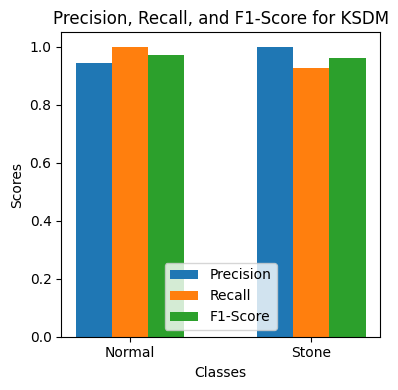

In [90]:
import numpy as np
rpt = classification_report(actual, predicted, target_names=['Normal', 'Stone'], output_dict=True)

# Extract precision, recall, and f1-score for each class
labels = ['Normal', 'Stone']
precision = [rpt['Normal']['precision'], rpt['Stone']['precision']]
recall = [rpt['Normal']['recall'], rpt['Stone']['recall']]
f1_score = [rpt['Normal']['f1-score'], rpt['Stone']['f1-score']]

# Set up bar positions and width
x = np.arange(len(labels))
width = 0.2  # Width of bars

# Plotting precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(4, 4))

# Bar plots
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

# Add labels, title, and custom ticks
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for KSDM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

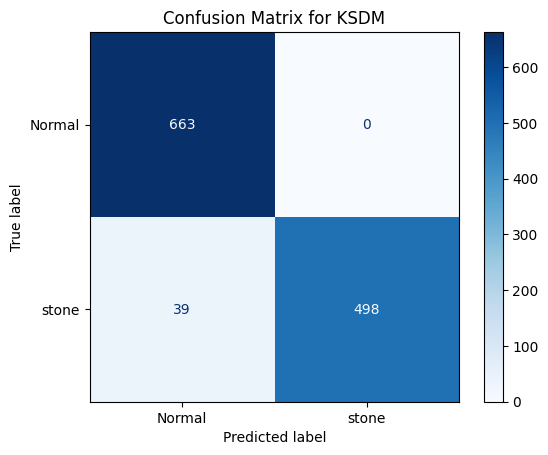

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert lists to numpy arrays
npredicted_classes = np.array(actual)
nactual_classes = np.array(predicted)

# Get unique class names from actual_classes
class_names = np.unique(actual)

# Compute confusion matrix
cm = confusion_matrix(actual, predicted, labels=class_names)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Use 'd' to display integer values
plt.title('Confusion Matrix for KSDM')
plt.show()


Confusion Matrix:
 [[663   0]
 [ 39 498]]


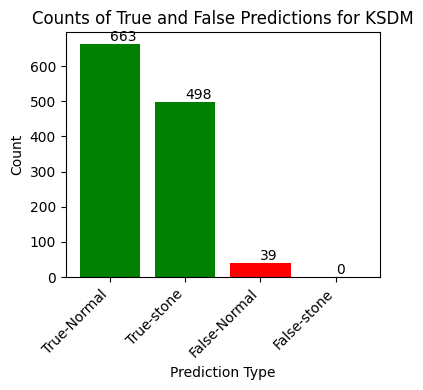

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume test_true and test_preds are the true labels and predicted labels respectively
# Define class names based on the labels present in test_true and test_preds
class_names = np.unique(np.concatenate((actual, predicted)))

# Compute confusion matrix
cm = confusion_matrix(actual, predicted, labels=class_names)
print("Confusion Matrix:\n", cm)

# Extract counts from confusion matrix
true_positives = np.diag(cm)
false_positives = cm.sum(axis=0) - true_positives
false_negatives = cm.sum(axis=1) - true_positives

# Prepare data for bar graph
labels = [f'True-{cls}' for cls in class_names] + [f'False-{cls}' for cls in class_names]
counts = list(true_positives) + list(false_positives)

# Plot bar graph
plt.figure(figsize=(4, 4))
bars = plt.bar(labels, counts, color=['green']*len(class_names) + ['red']*len(class_names))
plt.title('Counts of True and False Predictions for KSDM')
plt.xlabel('Prediction Type')
plt.ylabel('Count')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.savefig('prediction_counts.png')
plt.show()

In [93]:
import numpy as np

# Define the mapping
label_mapping = {'Normal': 0, 'stone': 1}
nactual = np.array([label_mapping[label] for label in actual])
npredicted = np.array([label_mapping[label] for label in predicted])

In [94]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Convert lists to numpy arrays
nnactual_classes = np.array(nactual)
nnpredicted_classes = np.array(npredicted)

# Compute Mean Absolute Error
mae = mean_absolute_error(nnactual_classes, nnpredicted_classes)

print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.0325


In [95]:
import numpy as np
from sklearn.metrics import matthews_corrcoef



# Compute Matthews Correlation Coefficient
mcc = matthews_corrcoef(actual, predicted)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Matthews Correlation Coefficient (MCC): 0.9359


In [96]:
#5. ROC AUC Score
#The ROC AUC Score measures the area under the ROC curve, providing an aggregate measure of performance across all classification thresholds.
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(nactual, npredicted)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.9637


In [97]:
#6. Cohen’s Kappa
#ECohen’s Kappa measures the agreement between observed and predicted classifications while accounting for chance.
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(actual, predicted)
print(f"Cohen’s Kappa: {kappa:.4f}")

Cohen’s Kappa: 0.9338


In [98]:
#9. Hamming Loss
#Hamming Loss measures the fraction of labels that are incorrectly predicted.
from sklearn.metrics import hamming_loss

hamming = hamming_loss(actual, predicted)
print(f"Hamming Loss: {hamming:.4f}")


Hamming Loss: 0.0325


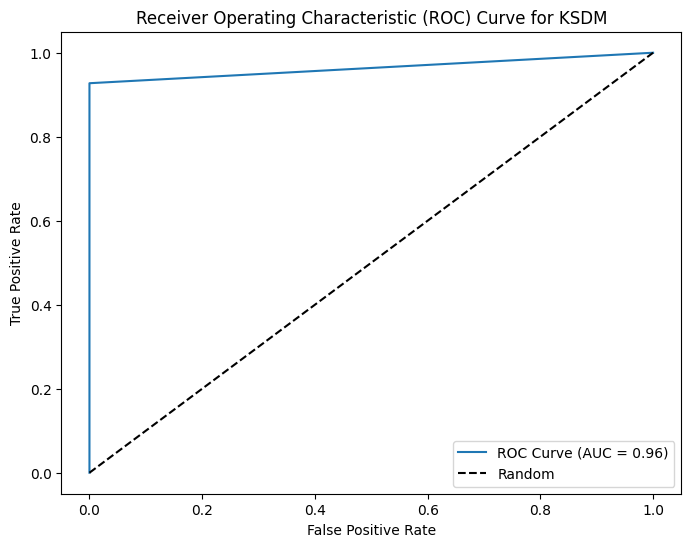

In [99]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'a' contains actual labels and 'p' contains predicted probabilities
# Replace them with your actual data

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(nactual, npredicted)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KSDM')
plt.legend(loc='lower right')
plt.show()

In [100]:
import pandas as pd
df1 = pd.DataFrame({
    'ImageName': imageName,
    'ActualClass': actual,
    'PredictedClass': predicted
})

# Save the DataFrame to CSV
df1.to_csv('/content/drive/MyDrive/kidney/output/results2Classes.csv', index=False)

print("CSV file saved as 'results.csv'")


CSV file saved as 'results.csv'


In [102]:
train_data_path = '/content/drive/MyDrive/kidney/ds/train/'
test_data_path = '/content/drive/MyDrive/kidney/ds/test/'

In [104]:
import os
def count_images_in_folders(data_path):
    class_counts = {}
    for folder in os.listdir(data_path):
        folder_path = os.path.join(data_path, folder)
        if os.path.isdir(folder_path):  # Check if it's a directory
            image_count = len([file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[folder] = image_count
    return class_counts

# Count images in train and test datasets
train_counts = count_images_in_folders(train_data_path)
test_counts = count_images_in_folders(test_data_path)

# Display the results
print("Training Set Class Counts:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nTest Set Class Counts:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

Training Set Class Counts:
Normal: 1200 images
stone: 800 images

Test Set Class Counts:
stone: 537 images
Normal: 663 images


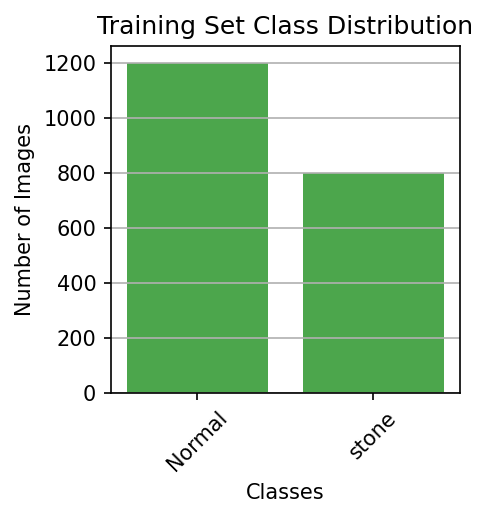

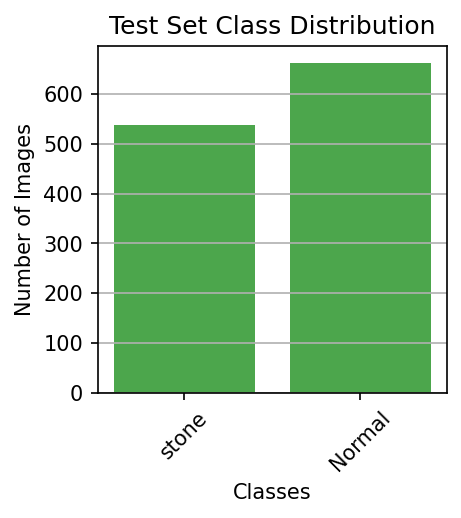

In [107]:
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(3, 3),dpi=150)
    plt.bar(classes, counts, color='green', alpha=0.7)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.grid(axis='y')
    plt.show()

# Plot training and testing class distributions
plot_class_distribution(train_counts, 'Training Set Class Distribution')
plot_class_distribution(test_counts, 'Test Set Class Distribution')

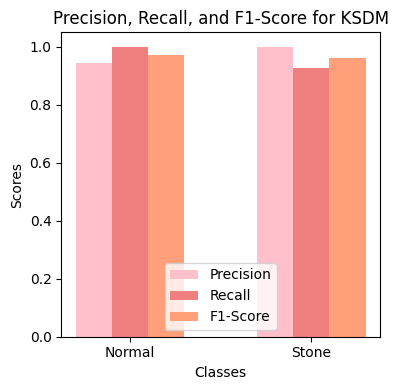

In [114]:
import numpy as np
rpt = classification_report(actual, predicted, target_names=['Normal', 'Stone'], output_dict=True)

# Extract precision, recall, and f1-score for each class
labels = ['Normal', 'Stone']
precision = [rpt['Normal']['precision'], rpt['Stone']['precision']]
recall = [rpt['Normal']['recall'], rpt['Stone']['recall']]
f1_score = [rpt['Normal']['f1-score'], rpt['Stone']['f1-score']]
# Set up bar positions and width
x = np.arange(len(labels))
width = 0.2  # Width of bars

# Plotting precision, recall, and f1-score
fig, ax = plt.subplots(figsize=(4, 4))

# Bar plots
ax.bar(x - width, precision, width, label='Precision', color='pink')
ax.bar(x, recall, width, label='Recall', color='lightcoral')
ax.bar(x + width, f1_score, width, label='F1-Score', color='lightsalmon')

# Add labels, title, and custom ticks
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for KSDM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

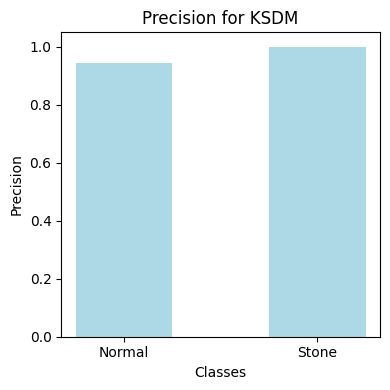

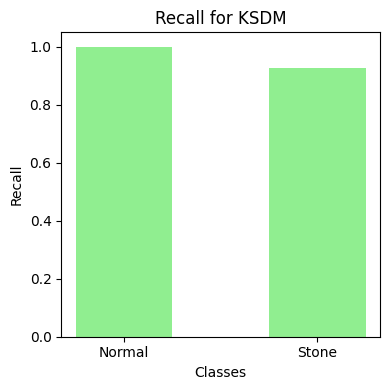

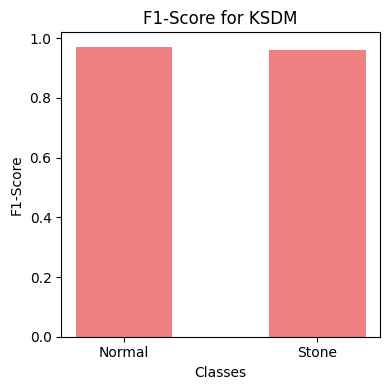

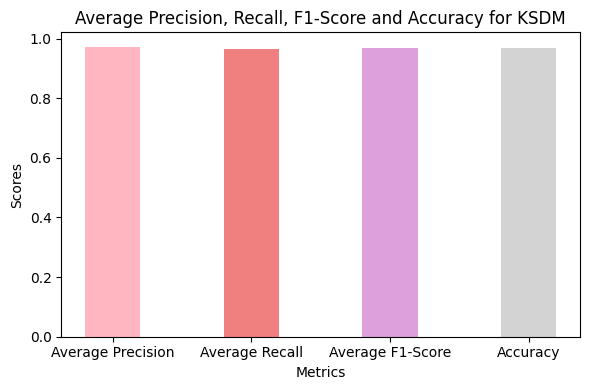

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Assume `actual` and `predicted` are already defined
rpt = classification_report(actual, predicted, target_names=['Normal', 'Stone'], output_dict=True)

# Extract precision, recall, and f1-score for each class
labels = [ 'Normal', 'Stone']
precision = [rpt['Normal']['precision'], rpt['Stone']['precision']]
recall = [rpt['Normal']['recall'], rpt['Stone']['recall']]
f1_score = [rpt['Normal']['f1-score'], rpt['Stone']['f1-score']]

# Calculate average and accuracy
avg_precision = rpt['macro avg']['precision']
avg_recall = rpt['macro avg']['recall']
avg_f1_score = rpt['macro avg']['f1-score']
overall_accuracy = accuracy_score(actual, predicted)

# X positions for bar plots
x = np.arange(len(labels))
width = 0.5  # Width of bars

# Function to create separate bar graphs
def create_bar_plot(metric, values, title, color):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar(x, values, width, label=metric, color=color)

    # Add labels, title, and custom ticks
    ax.set_xlabel('Classes')
    ax.set_ylabel(metric)
    ax.set_title(f'{title} for KSDM')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    plt.tight_layout()
    plt.show()

# Precision plot
create_bar_plot('Precision', precision, 'Precision', 'lightblue')

# Recall plot
create_bar_plot('Recall', recall, 'Recall', 'lightgreen')

# F1-Score plot
create_bar_plot('F1-Score', f1_score, 'F1-Score', 'lightcoral')

# Overall average precision, recall, f1-score, and accuracy
metrics = ['Average Precision', 'Average Recall', 'Average F1-Score', 'Accuracy']
values = [avg_precision, avg_recall, avg_f1_score, overall_accuracy]
colors = ['lightpink', 'lightcoral', 'plum', 'lightgray']

# Average and accuracy plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(metrics, values, width=0.4, color=colors)

# Add labels, title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Average Precision, Recall, F1-Score and Accuracy for KSDM')
plt.tight_layout()
plt.show()
